In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

## Load in data

In [2]:
folder_path = user_path + '/PHYS469/saturation_spectroscopy/raw_data/10-31-2024/'
raw_probe_pump_data = {}
raw_probe_data = {}

for file_name in os.listdir(folder_path):
    file_name = file_name.strip()
    # Read the lines of the file
    with open(folder_path+file_name, 'r') as f:
        lines = f.readlines()
    # Find end of the header (the line that starts with 'x ys')
    for i, line in enumerate(lines):
        if line.startswith('x	y'):
            lines_to_skip = i
            break

    # Read data (skip header)
    data = np.genfromtxt(folder_path+file_name, skip_header=lines_to_skip, names=True, missing_values='_', filling_values=0)
    reshaped_data = np.vstack([data[field] for field in data.dtype.names]).T

    # Make a dict for the run
    file_dict = {label: reshaped_data[:,i] for i,label in enumerate(data.dtype.names)}
    # Add dict to data dict
    if 'run' in file_name:
        raw_probe_pump_data[file_name[:-4]] = file_dict
    else:
        raw_probe_data[file_name[:-4]] = file_dict

In [4]:
# showing keys for example
raw_probe_pump_data.keys(), raw_probe_data.keys(), raw_probe_pump_data['run1'].keys()

(dict_keys(['run20', 'run9', 'run8', 'run19', 'run18', 'run6', 'run15', 'run14', 'run7', 'run5', 'run16', 'run17', 'run4', 'run13', 'run12', 'run1', 'run3', 'run10', 'run11', 'run2']),
 dict_keys(['nopump17', 'nopump16', 'nopump14', 'nopump15', 'nopump11', 'nopump10', 'nopump12', 'nopump13', 'nopump2', 'nopump3', 'nopump1', 'nopump4', 'nopump5', 'nopump7', 'nopump6', 'nopump8', 'nopump9', 'nopump20', 'nopump18', 'nopump19']),
 dict_keys(['x', 'y2', 'y3']))

## Identifying peaks in hyperfine runs

(690.0, 720.0)

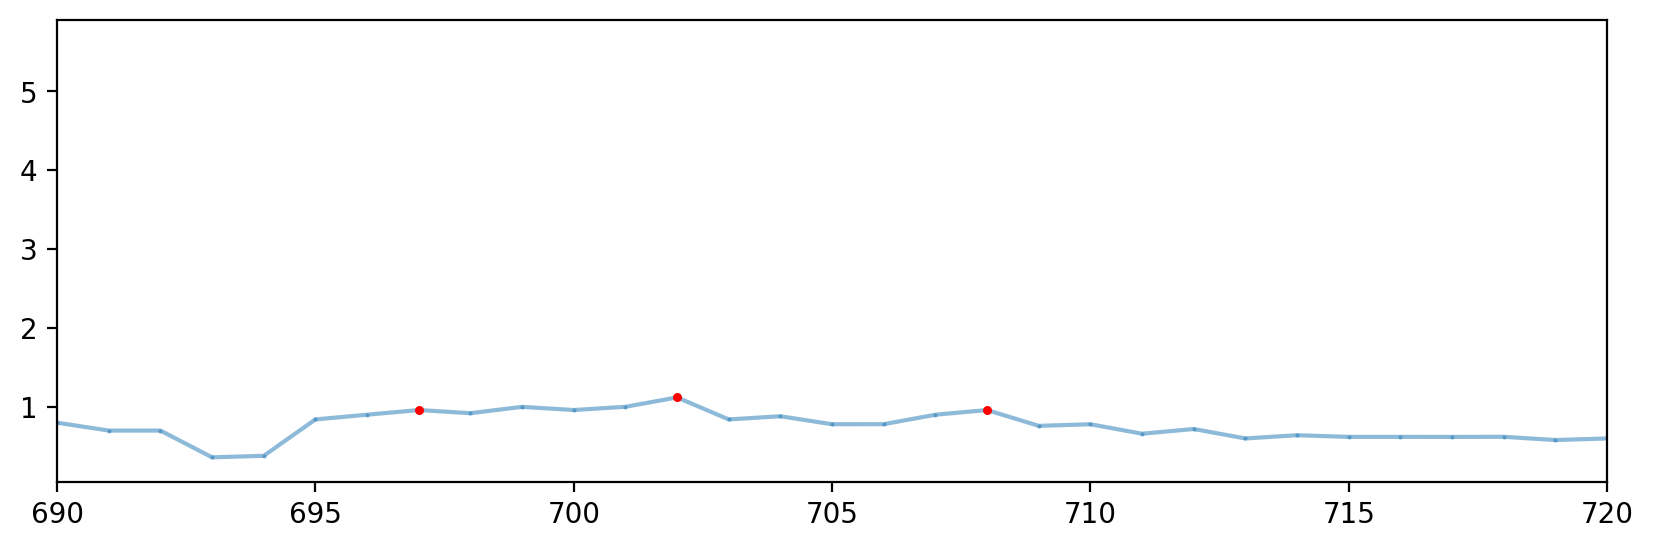

In [437]:
i = 1
# loading run
probe_data = raw_probe_pump_data['run'+str(i)]['y2'] - raw_probe_data['nopump1']['y2']

plt.figure(figsize = (10, 3), dpi = 200)
plt.plot(np.arange(len(probe_data)), probe_data, zorder = 0, marker = '.', markersize = 1, alpha = 0.5)

# choosing indices of peaks
indices = [118, 127, 157,    245, 255, 265,    503, 507, 512,    697, 702, 708]

# plotting these points from the original data
plt.scatter(indices, probe_data[indices], color='r', s = 5)

plt.xlim(50, 800)

# to zoom in on specific peak
# plt.xlim(115, 165)
# plt.xlim(240, 270)
# plt.xlim(495, 520)
# plt.xlim(685,720)

In [304]:
# FINDING THE HYPERFINE PEAK INDICES BY HAND FOR EACH RUN :(
hyperfine_peaks = {
    'run1':     [118, 127, 157,    245, 255, 265,    503, 507, 512,    697, 702, 708], 
    'run2':     [118, 127, 157,    245, 255, 265,    503, 507, 512,    697, 702, 708],
    'run3':     [118, 127, 157,    245, 255, 264,    503, 507, 512,    697, 702, 708],
    'run4':     [118, 127, 157,    245, 253, 264,    503, 507, 512,    697, 702, 708],
    'run5':     [118, 127, 156,    245, 253, 264,    503, 507, 512,    697, 702, 708],
    'run6':     [118, 127, 156,    245, 253, 264,    503, 507, 512,    697, 702, 708],
    'run7':     [118, 126, 156,    245, 253, 264,    503, 507, 512,    696, 702, 708],
    'run8':     [118, 126, 156,    245, 253, 264,    503, 507, 512,    696, 702, 708],
    'run9':     [117, 126, 156,    245, 253, 264,    503, 507, 512,    696, 702, 708],
    'run10':    [118, 126, 156,    245, 253, 264,    503, 507, 512,    696, 702, 708],
    'run11':    [111, 121, 150,    245, 253, 263,    503, 507, 512,    698, 703, 709],
    'run12':    [109, 119, 149,    245, 253, 263,    503, 507, 512,    698, 703, 709],
    'run13':    [109, 118, 148,    245, 253, 263,    503, 507, 512,    698, 703, 709],
    'run14':    [109, 118, 148,    245, 253, 263,    503, 507, 512,    698, 704, 710],
    'run15':    [109, 117, 147,    243, 251, 263,    503, 507, 512,    698, 704, 710],
    'run16':    [108, 117, 147,    243, 251, 263,    503, 507, 512,    698, 704, 710],
    'run17':    [108, 117, 147,    243, 251, 263,    503, 507, 512,    698, 704, 710],
    'run18':    [107, 115, 146,    243, 251, 262,    501, 505, 512,    698, 703, 709],
    'run19':    [107, 115, 146,    243, 251, 262,    501, 503, 512,    698, 703, 709],
    'run20':    [107, 115, 146,    243, 251, 262,    501, 503, 512,    698, 703, 709],
}

## Defining fit for interferometer data

$$ I(t) = A + A\cos\left(\frac{4\pi\Delta L}{c} f(t)\right) + g(t) $$
where f(t) is the frequency sweep, and g(t) is the ramp, with
$$ f(t) = f_o + \alpha t + \beta t^2 $$
and
$$ g(t) = a + bt $$

In [305]:
def interference_model(t, f0, alpha, A, a, b, beta):
    delta_L = 0.34      # path difference in m
    c = 3e8             # speed of light in m/s
    f_t = f0 + alpha * t + beta*t**2            # quadratic model for the frequency sweep f(t)
    phase = (4 * np.pi * delta_L / c) * f_t     # phase expression from lab manual
    ramp = a + b*t                              # linear model for the ramp g(t)
    return A * (1 + np.cos(phase)) + ramp

## Converting all runs to frequency space

f0=1.00e+14 ± 3.66e+06
 alpha=3.47e+11 ± 9.16e+08
 A=6.45e-01 ± 6.75e-03
 a=3.45e+00 ± 1.32e-02
 b=-1.08e+02 ± 1.18e+00
 beta=4.92e+12 ± 5.02e+10


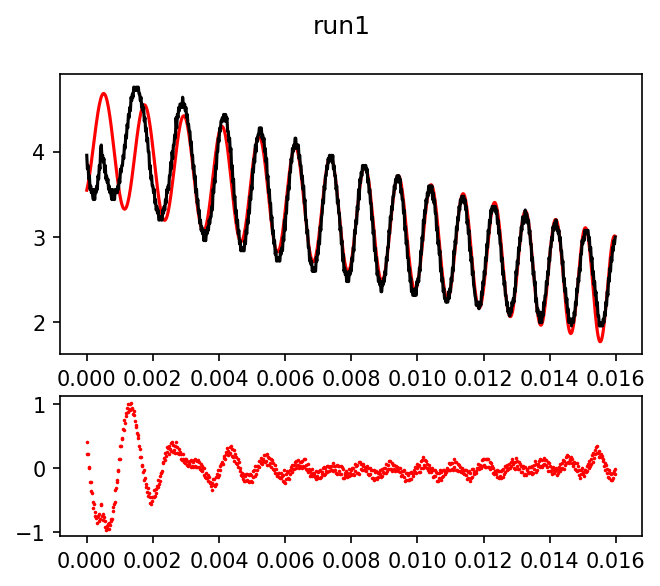

f0=1.00e+14 ± 3.66e+06
 alpha=3.47e+11 ± 9.16e+08
 A=6.45e-01 ± 6.75e-03
 a=3.45e+00 ± 1.32e-02
 b=-1.09e+02 ± 1.18e+00
 beta=4.95e+12 ± 5.02e+10


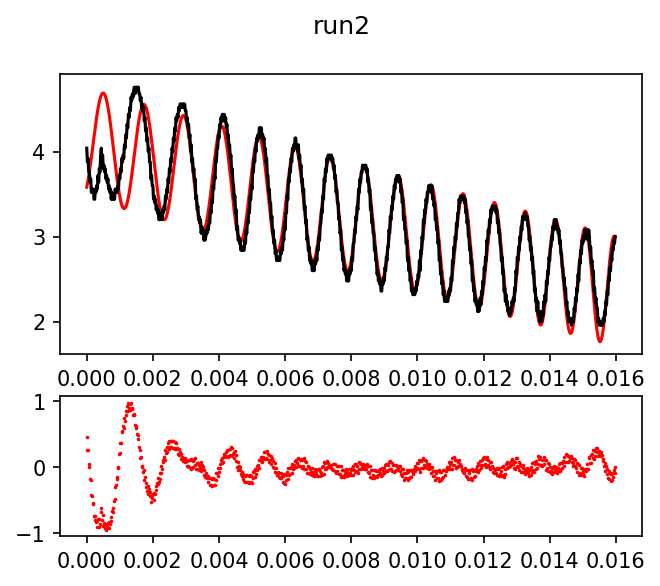

f0=1.00e+14 ± 3.64e+06
 alpha=3.48e+11 ± 9.09e+08
 A=6.43e-01 ± 6.54e-03
 a=3.47e+00 ± 1.28e-02
 b=-1.10e+02 ± 1.15e+00
 beta=4.91e+12 ± 4.97e+10


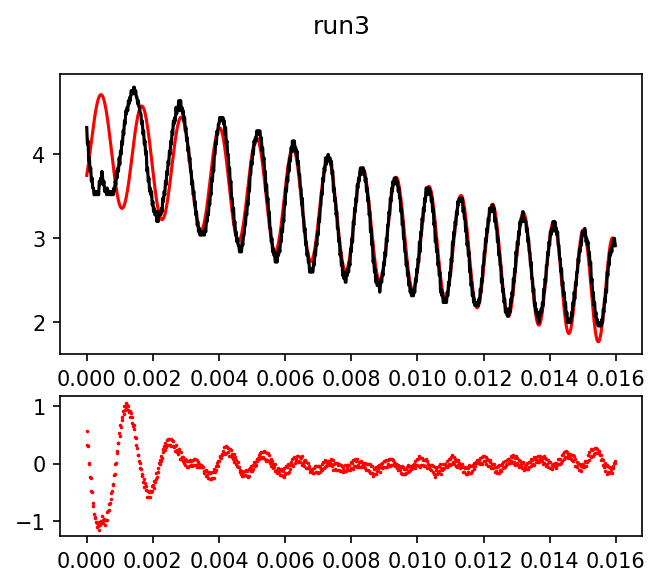

f0=1.00e+14 ± 3.82e+06
 alpha=3.47e+11 ± 9.52e+08
 A=6.43e-01 ± 6.80e-03
 a=3.48e+00 ± 1.33e-02
 b=-1.10e+02 ± 1.20e+00
 beta=4.93e+12 ± 5.20e+10


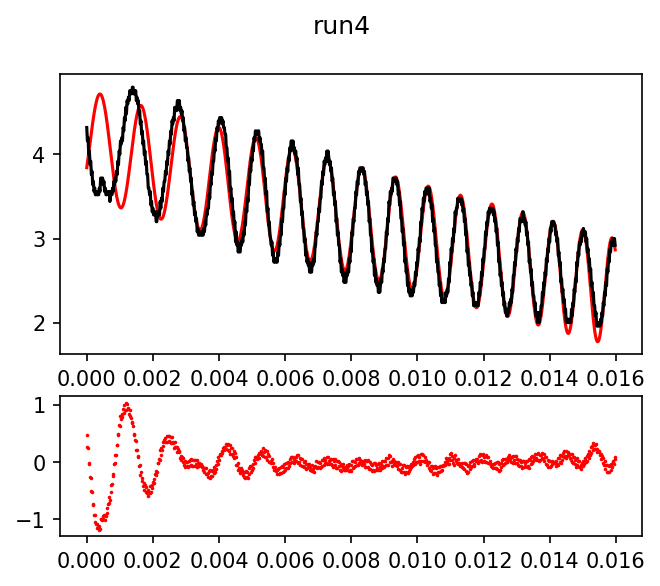

f0=1.00e+14 ± 3.81e+06
 alpha=3.48e+11 ± 9.46e+08
 A=6.43e-01 ± 6.70e-03
 a=3.48e+00 ± 1.31e-02
 b=-1.11e+02 ± 1.18e+00
 beta=4.88e+12 ± 5.16e+10


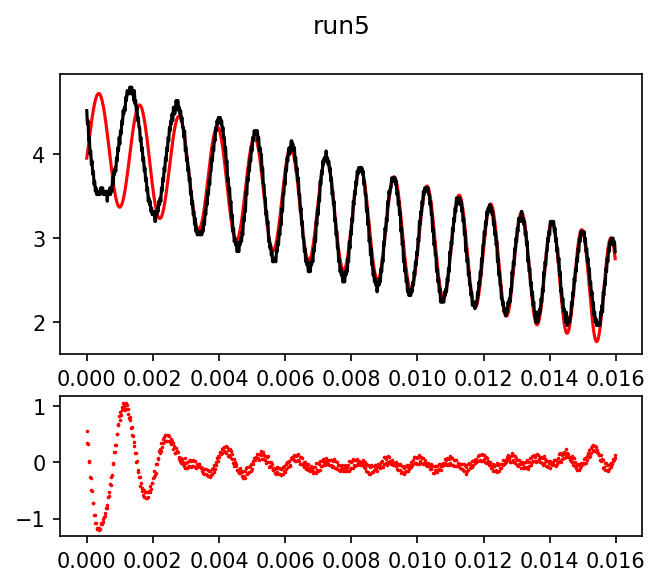

f0=1.00e+14 ± 3.88e+06
 alpha=3.48e+11 ± 9.60e+08
 A=6.46e-01 ± 6.82e-03
 a=3.50e+00 ± 1.34e-02
 b=-1.12e+02 ± 1.20e+00
 beta=4.90e+12 ± 5.22e+10


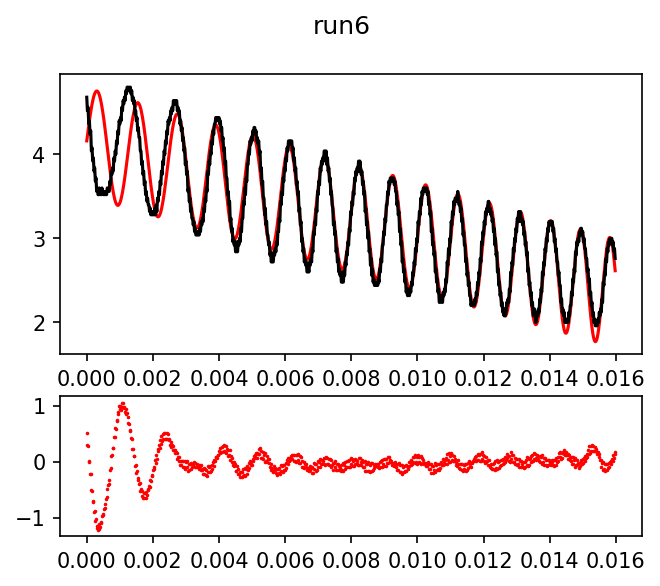

f0=1.00e+14 ± 3.89e+06
 alpha=3.48e+11 ± 9.61e+08
 A=6.43e-01 ± 6.79e-03
 a=3.50e+00 ± 1.34e-02
 b=-1.12e+02 ± 1.19e+00
 beta=4.90e+12 ± 5.22e+10


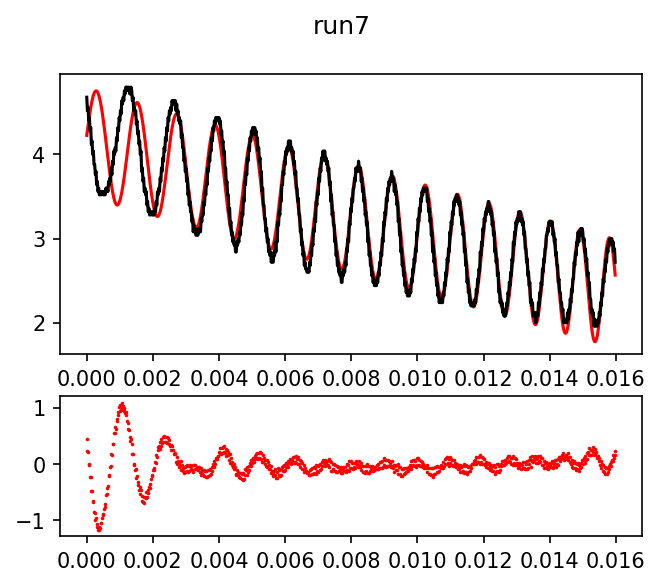

f0=1.00e+14 ± 3.88e+06
 alpha=3.47e+11 ± 9.61e+08
 A=6.42e-01 ± 6.77e-03
 a=3.51e+00 ± 1.33e-02
 b=-1.12e+02 ± 1.19e+00
 beta=4.91e+12 ± 5.22e+10


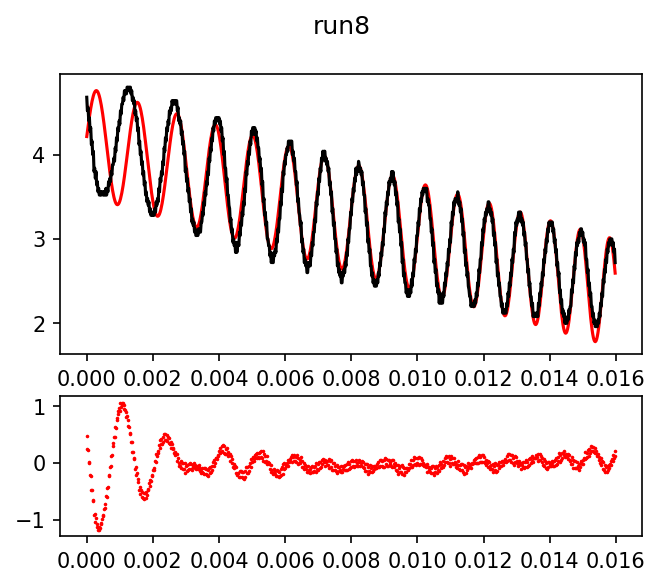

f0=1.00e+14 ± 4.06e+06
 alpha=3.46e+11 ± 1.00e+09
 A=-6.40e-01 ± 7.18e-03
 a=4.77e+00 ± 1.45e-02
 b=-1.12e+02 ± 1.26e+00
 beta=4.94e+12 ± 5.45e+10


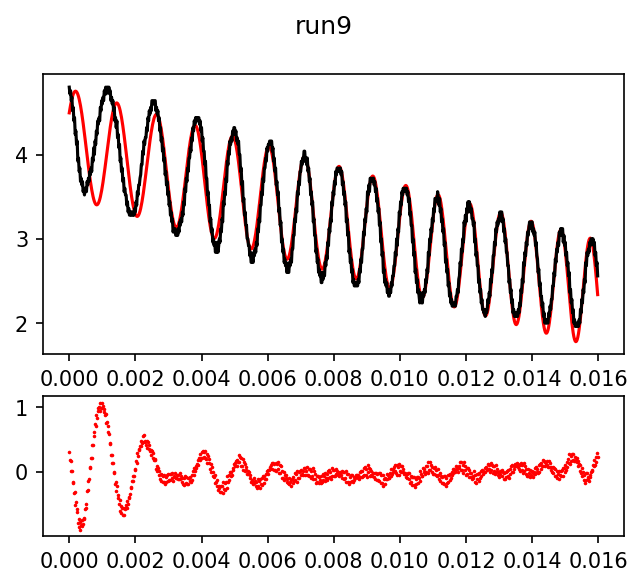

f0=1.00e+14 ± 4.02e+06
 alpha=3.45e+11 ± 9.96e+08
 A=-6.40e-01 ± 7.25e-03
 a=4.79e+00 ± 1.45e-02
 b=-1.13e+02 ± 1.27e+00
 beta=4.97e+12 ± 5.41e+10


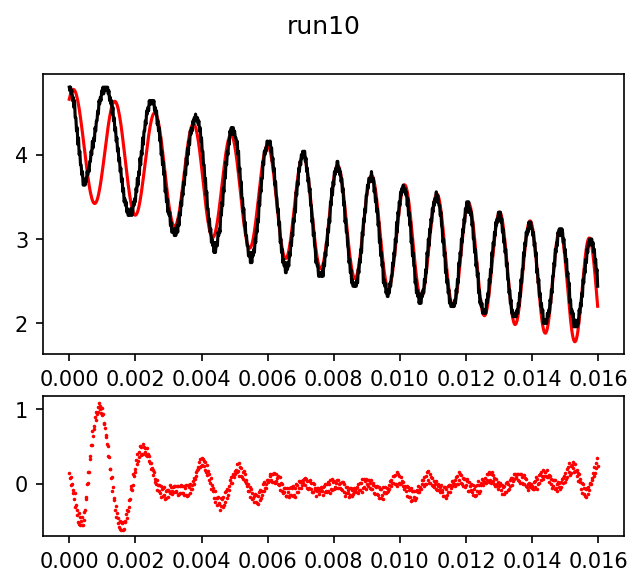

f0=1.00e+14 ± 4.43e+06
 alpha=3.38e+11 ± 1.10e+09
 A=6.36e-01 ± 7.86e-03
 a=3.55e+00 ± 1.57e-02
 b=-1.14e+02 ± 1.38e+00
 beta=5.25e+12 ± 6.01e+10


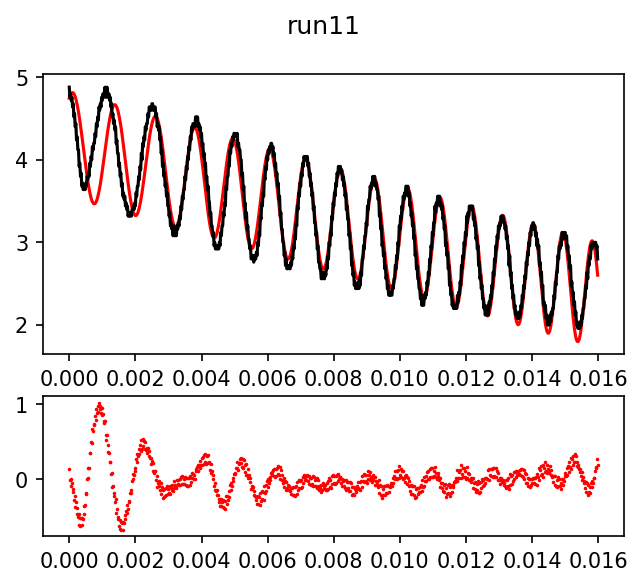

f0=1.00e+14 ± 4.58e+06
 alpha=3.35e+11 ± 1.14e+09
 A=6.35e-01 ± 8.24e-03
 a=3.55e+00 ± 1.64e-02
 b=-1.13e+02 ± 1.44e+00
 beta=5.36e+12 ± 6.24e+10


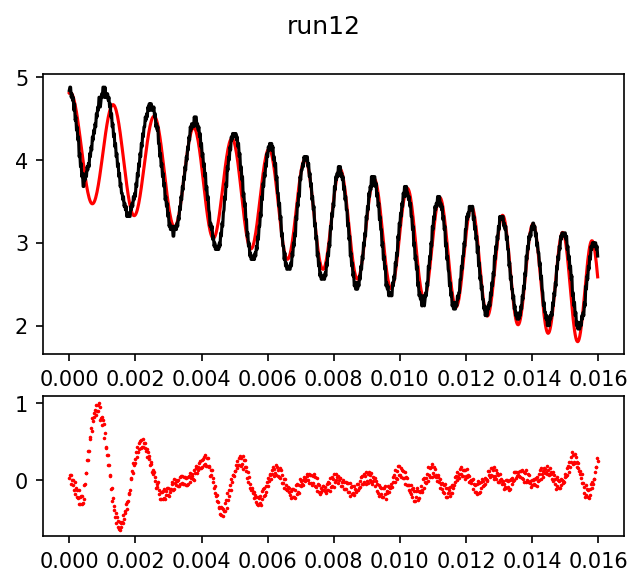

f0=1.00e+14 ± 4.67e+06
 alpha=3.33e+11 ± 1.17e+09
 A=6.34e-01 ± 8.45e-03
 a=3.55e+00 ± 1.69e-02
 b=-1.13e+02 ± 1.48e+00
 beta=5.40e+12 ± 6.39e+10


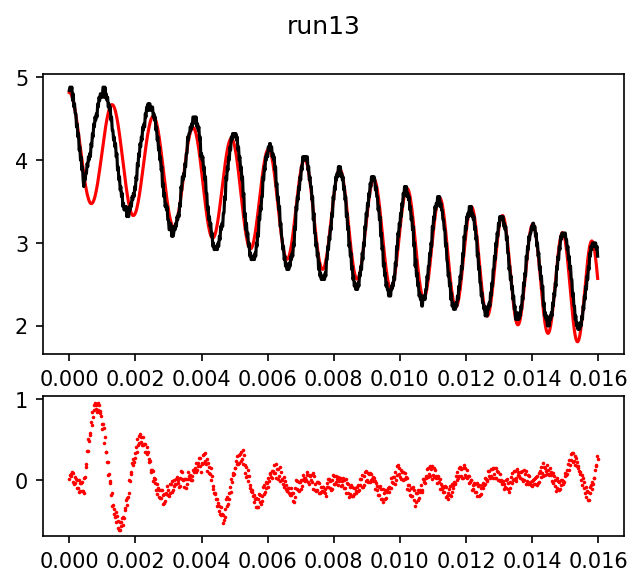

f0=1.00e+14 ± 5.07e+06
 alpha=3.34e+11 ± 1.27e+09
 A=6.27e-01 ± 8.97e-03
 a=3.56e+00 ± 1.79e-02
 b=-1.14e+02 ± 1.57e+00
 beta=5.38e+12 ± 6.92e+10


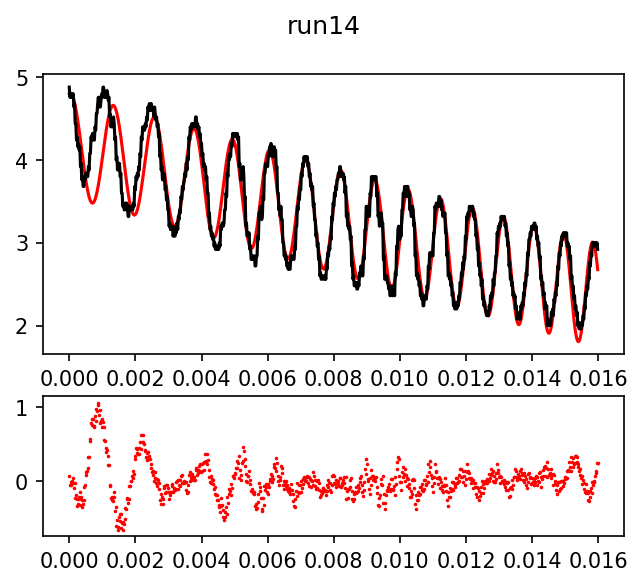

f0=1.00e+14 ± 4.84e+06
 alpha=3.32e+11 ± 1.21e+09
 A=6.32e-01 ± 8.60e-03
 a=3.54e+00 ± 1.72e-02
 b=-1.13e+02 ± 1.51e+00
 beta=5.46e+12 ± 6.60e+10


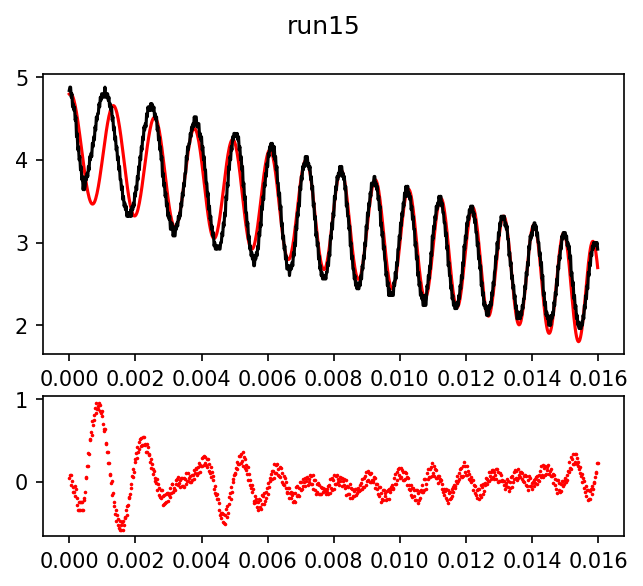

f0=1.00e+14 ± 4.64e+06
 alpha=3.33e+11 ± 1.16e+09
 A=6.33e-01 ± 8.30e-03
 a=3.55e+00 ± 1.66e-02
 b=-1.13e+02 ± 1.46e+00
 beta=5.42e+12 ± 6.34e+10


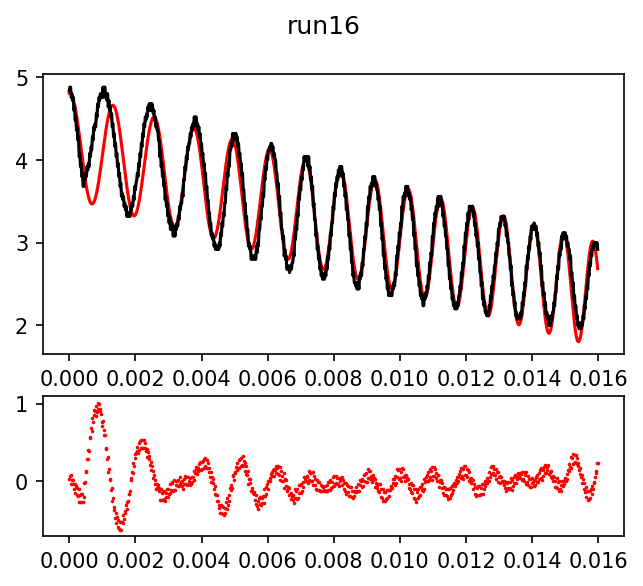

f0=1.00e+14 ± 4.74e+06
 alpha=3.32e+11 ± 1.18e+09
 A=6.31e-01 ± 8.49e-03
 a=3.55e+00 ± 1.70e-02
 b=-1.13e+02 ± 1.49e+00
 beta=5.47e+12 ± 6.48e+10


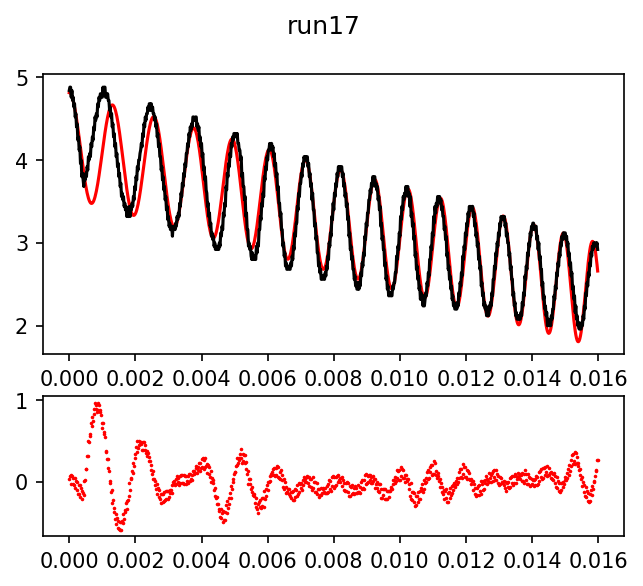

f0=1.00e+14 ± 4.75e+06
 alpha=3.31e+11 ± 1.19e+09
 A=6.32e-01 ± 8.52e-03
 a=3.54e+00 ± 1.70e-02
 b=-1.13e+02 ± 1.49e+00
 beta=5.49e+12 ± 6.51e+10


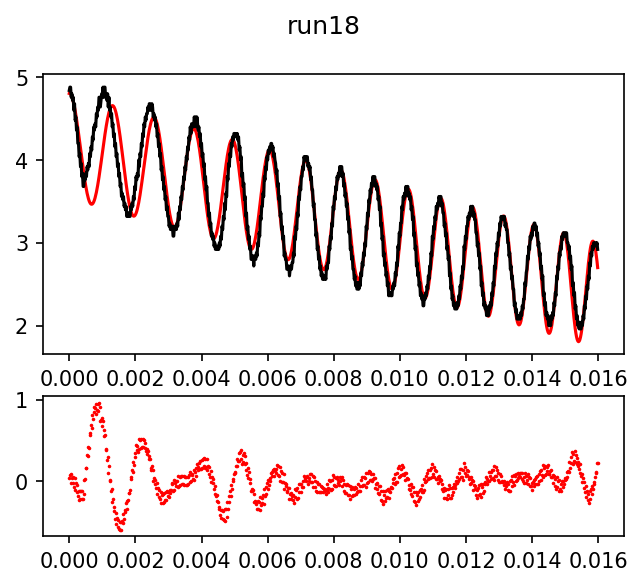

f0=1.00e+14 ± 4.76e+06
 alpha=3.31e+11 ± 1.19e+09
 A=6.32e-01 ± 8.63e-03
 a=3.54e+00 ± 1.73e-02
 b=-1.12e+02 ± 1.51e+00
 beta=5.52e+12 ± 6.52e+10


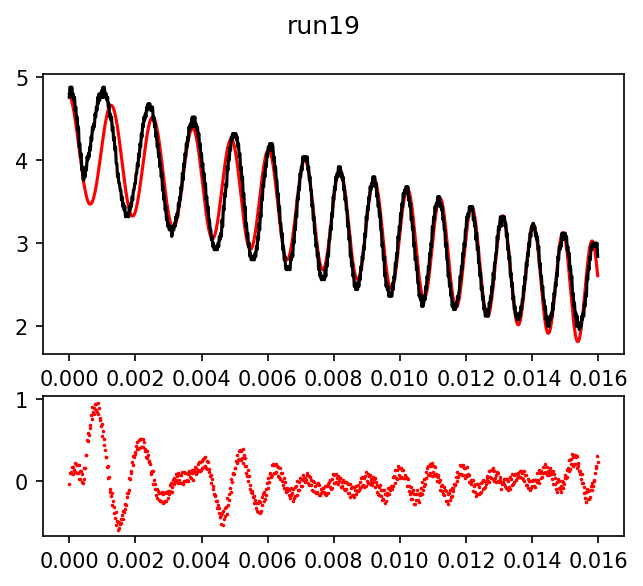

f0=1.00e+14 ± 3.83e+07
 alpha=4.20e+11 ± 9.51e+09
 A=2.27e-01 ± 2.40e-02
 a=3.96e+00 ± 4.80e-02
 b=-1.12e+02 ± 4.23e+00
 beta=-3.14e+12 ± 5.18e+11


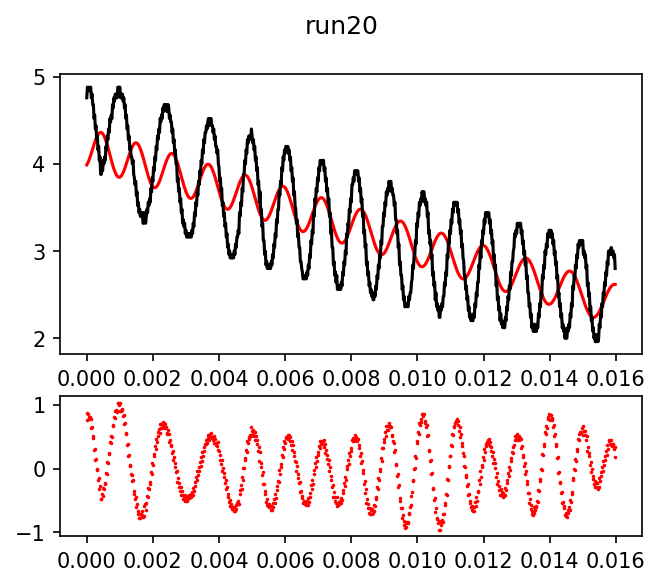

In [367]:
hyperfine_freq_gaps = {}
parameters = []
for run in hyperfine_peaks.keys():

    # load in hyperfine peak locations
    hyperfine_indices = hyperfine_peaks[run]

    # load in data and trim 
    inter_data = raw_probe_pump_data[run]['y3'][:800]
    time = raw_probe_pump_data[run]['x'][:800] / 10 # divide by 10 to convert to seconds

    # fit the interferometer data to the function
    alpha_guess = 4e11 if i==9 else 4.3e11
    initial_guess = [1e14, alpha_guess, 1, 4.5, -100, 1e12]  # f0, alpha, A, a, b, beta

    params, covariance = opt.curve_fit(interference_model, time[100:], inter_data[100:], p0=initial_guess, maxfev=1000000000)
    errors = np.sqrt(np.diag(covariance))

    if run == 'run1': parameters = params

    print(f'f0={params[0]:.2e} ± {errors[0]:.2e}\n',
            f'alpha={params[1]:.2e} ± {errors[1]:.2e}\n',
            f'A={params[2]:.2e} ± {errors[2]:.2e}\n',
            f'a={params[3]:.2e} ± {errors[3]:.2e}\n',
            f'b={params[4]:.2e} ± {errors[4]:.2e}\n',
            f'beta={params[5]:.2e} ± {errors[5]:.2e}')
    
    # plot the fit
    fig, axes = plt.subplots(2, 1, figsize=(5,4), dpi=150, gridspec_kw={'height_ratios': [2, 1]})
    fig.suptitle(f'{run}')
    axes[0].plot(time, interference_model(time, *params), color = 'r')
    axes[0].plot(time, inter_data, color = 'k')
    axes[1].scatter(time, inter_data-interference_model(time, *params), color = 'r', s=0.5)
    plt.show()
    
    # create the frequency function for this run
    def f(t, f0, alpha, beta):
            return f0 + alpha * t + beta * t**2
    
    # convert hyperfine peaks to frequency
    hyperfine_peaks_time = hyperfine_peaks[run]
    hyperfine_peak_freqs = f(time[hyperfine_peaks_time], params[0], params[1], params[5])
    
    # calculate the frequency gaps
    hyperfine_freq_gaps[run] = np.diff(hyperfine_peak_freqs)


## Displaying gap results

Average Frequency Gap: 6.41e+07 ± 4.61e+06
Average Frequency Gap: 2.21e+08 ± 4.09e+06
Average Frequency Gap: 7.03e+08 ± 1.95e+07
Average Frequency Gap: 6.52e+07 ± 6.15e+06
Average Frequency Gap: 8.45e+07 ± 5.94e+06
Average Frequency Gap: 2.01e+09 ± 1.31e+07
Average Frequency Gap: 3.46e+07 ± 4.01e+06
Average Frequency Gap: 4.73e+07 ± 8.55e+06
Average Frequency Gap: 1.72e+09 ± 4.97e+06
Average Frequency Gap: 5.26e+07 ± 4.78e+06
Average Frequency Gap: 5.83e+07 ± 3.11e+04


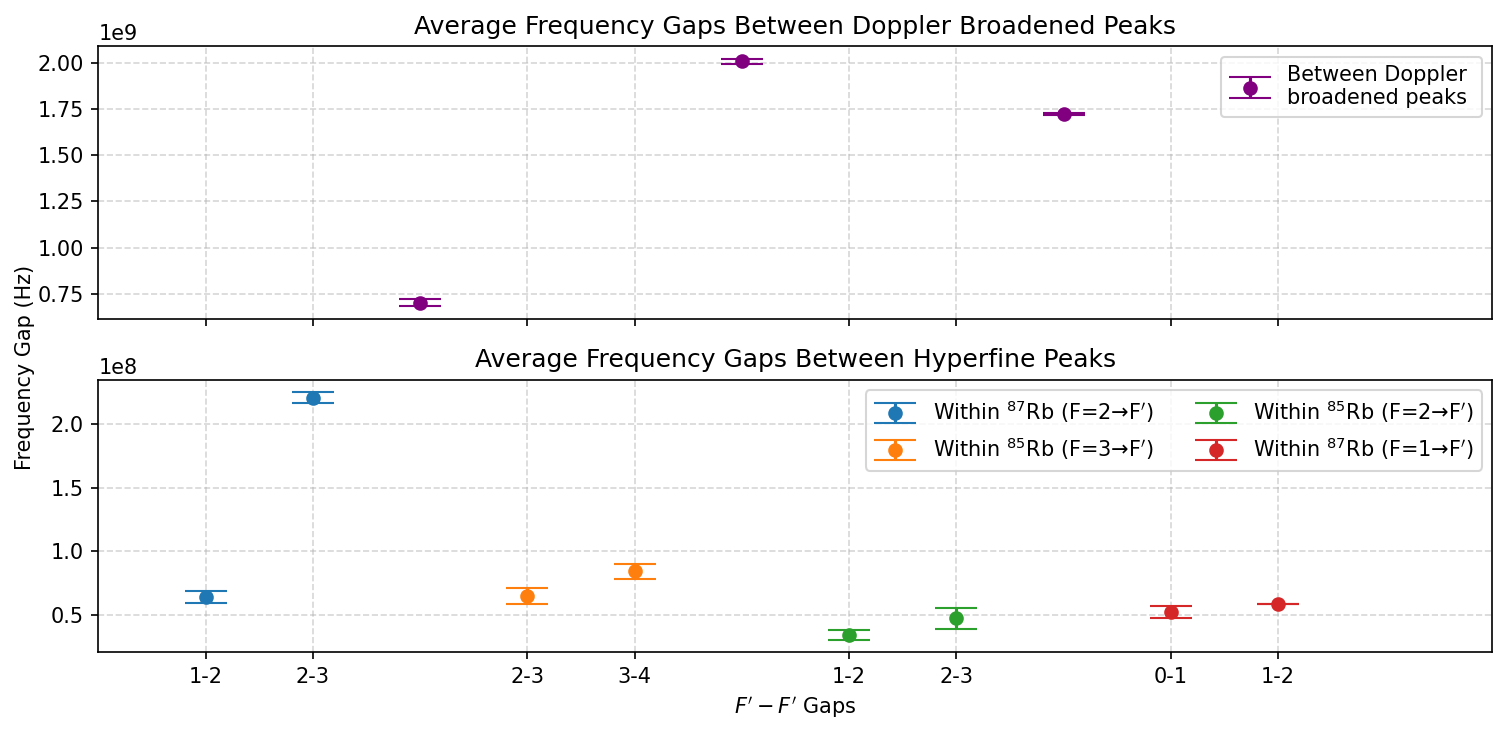

In [470]:
# calculate the average frequency gap
average_freq_gaps = np.mean([hyperfine_freq_gaps['run'+str(i)] for i in range(1, 20)], axis = 0)
std_freq_gap = np.std([hyperfine_freq_gaps['run'+str(i)] for i in range(1, 20)], axis=0)

for avg_gap, std_gap in zip(average_freq_gaps, std_freq_gap):
    print(f'Average Frequency Gap: {avg_gap:.2e} ± {std_gap:.2e}')

# plot the average frequency gap
plt.figure(figsize=(10,5), dpi=150)
hyperfine_indices = [0,1,3,4,6,7,9,10]
doppler_indices = [2,5,8,11]

# plotting gaps between doppler broadened peaks
plt.subplot(211)
plt.title('Average Frequency Gaps Between Doppler Broadened Peaks')
plt.errorbar([2, 5, 8], average_freq_gaps[[2,5,8]], yerr=std_freq_gap[[2,5,8]], fmt='o', capsize=10, label = 'Between Doppler \nbroadened peaks', color = 'purple')
plt.xlim(-1, 12)
plt.xticks([0, 1, 3, 4, 6, 7, 9, 10], labels=[])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# gaps between hyperfine peaks
plt.subplot(212)
plt.title('Average Frequency Gaps Between Hyperfine Peaks')
plt.errorbar([0, 1], average_freq_gaps[[0,1]], yerr=std_freq_gap[[0,1]], fmt='o', capsize=10, label = r'Within $^{87}$Rb (F=2$\to$F$^{\prime}$)')
plt.errorbar([3, 4], average_freq_gaps[[3,4]], yerr=std_freq_gap[[3,4]], fmt='o', capsize=10, label = r'Within $^{85}$Rb (F=3$\to$F$^{\prime}$)')
plt.errorbar([6, 7], average_freq_gaps[[6,7]], yerr=std_freq_gap[[6,7]], fmt='o', capsize=10, label = r'Within $^{85}$Rb (F=2$\to$F$^{\prime}$)')
plt.errorbar([9, 10], average_freq_gaps[[9,10]], yerr=std_freq_gap[[9,10]], fmt='o', capsize=10, label = r'Within $^{87}$Rb (F=1$\to$F$^{\prime}$)')

plt.xticks([0, 1, 3, 4, 6, 7, 9, 10], ['1-2', '2-3', '2-3', '3-4', '1-2', '2-3', '0-1', '1-2'])
plt.xlabel(r'$F^{\prime}-F^{\prime}$ Gaps')
plt.legend(ncol = 2)
plt.xlim(-1, 12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add a common y-axis label
plt.gcf().text(0.0, 0.5, 'Frequency Gap (Hz)', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

## Multipanel plot: showing data processing on a single run

Showing: 
- The pump - no pump data that we used to get the peaks
- The peaks highlighted and annotated
- the interferometer data for that run with fit and residuals

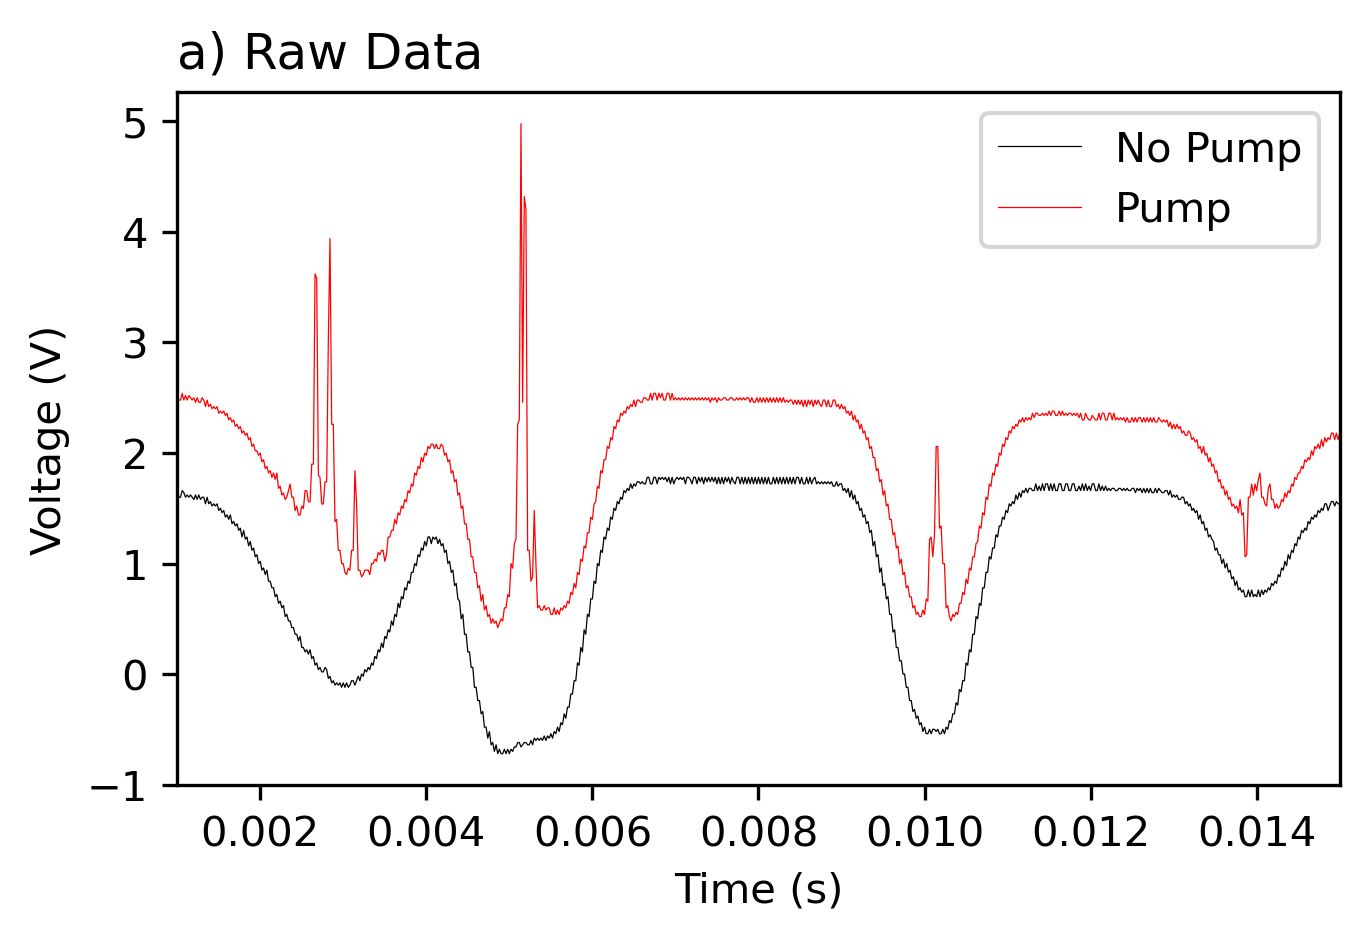

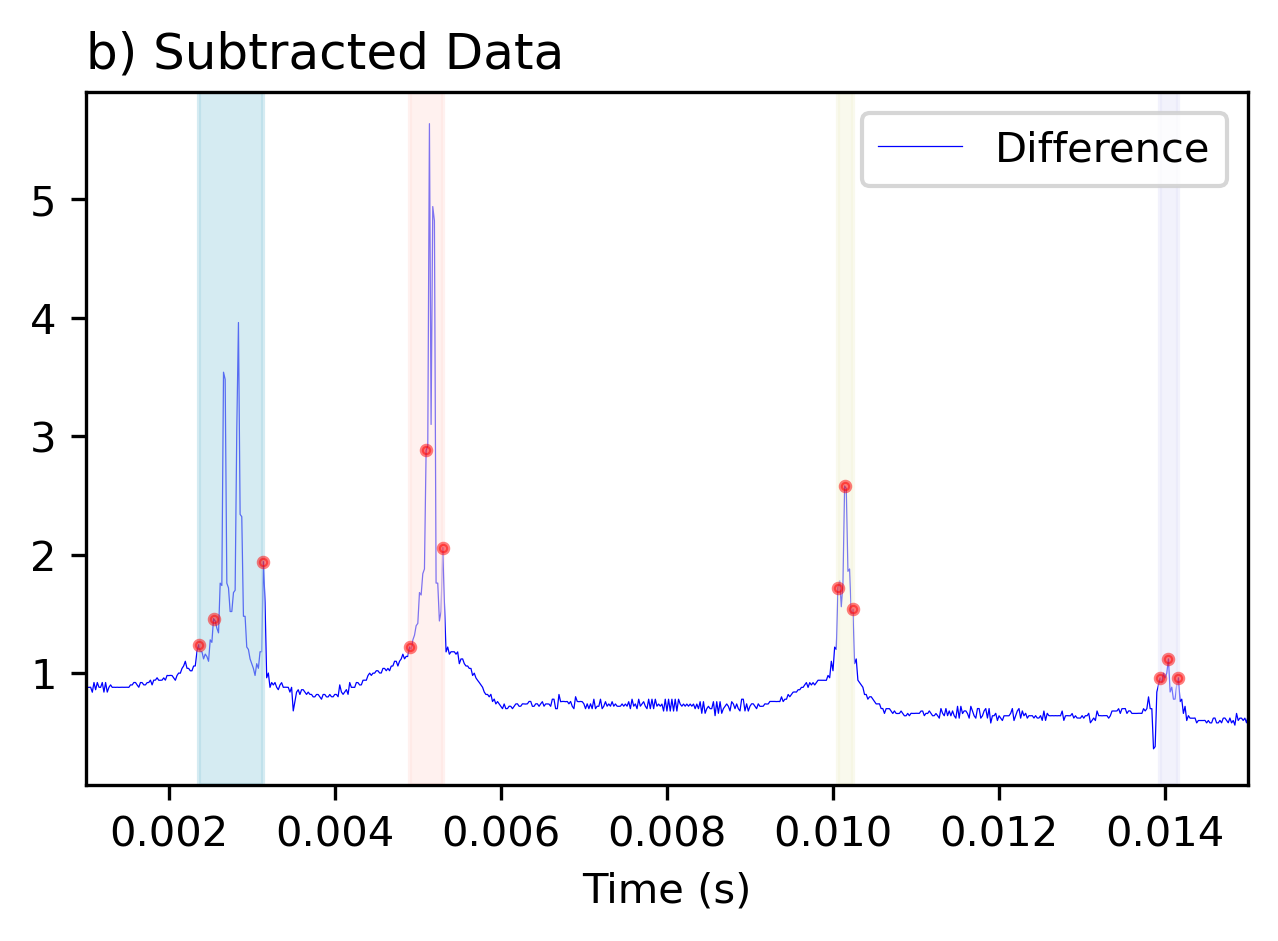

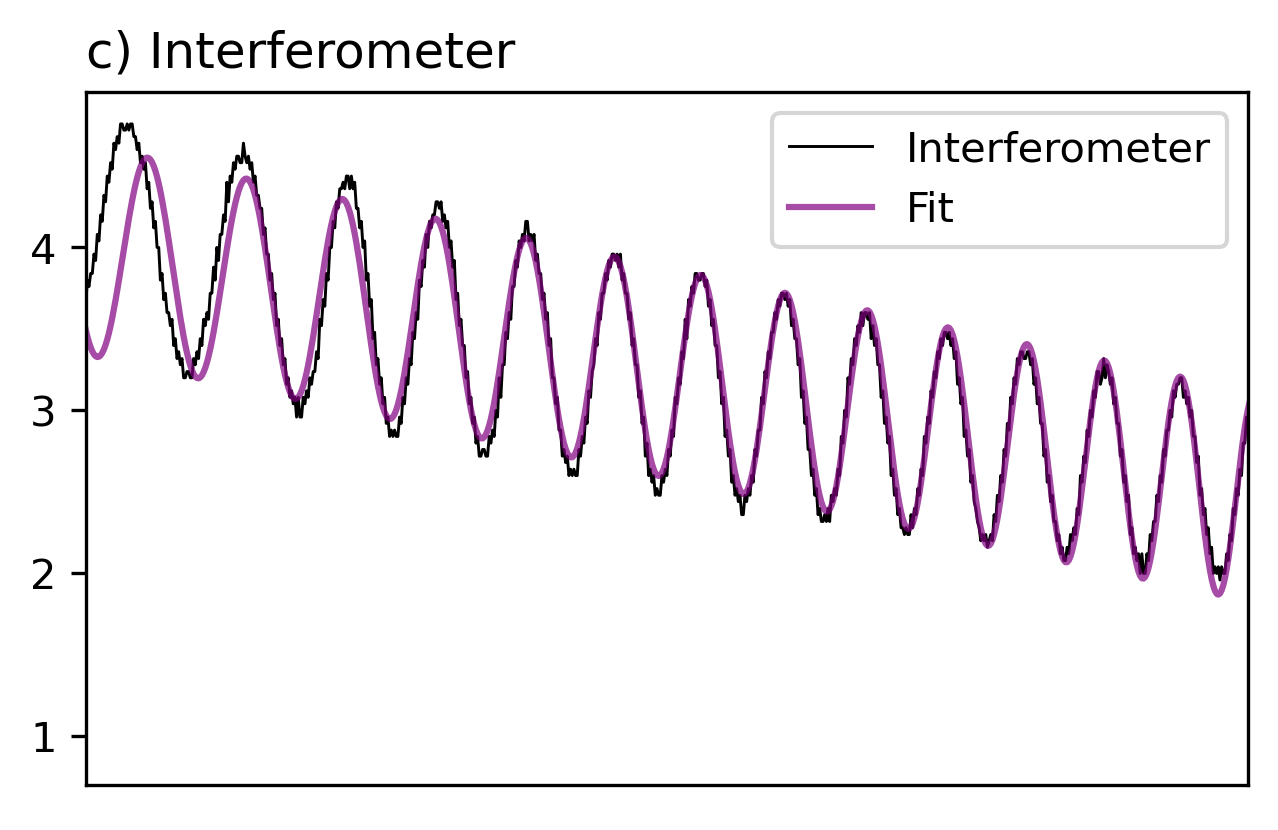

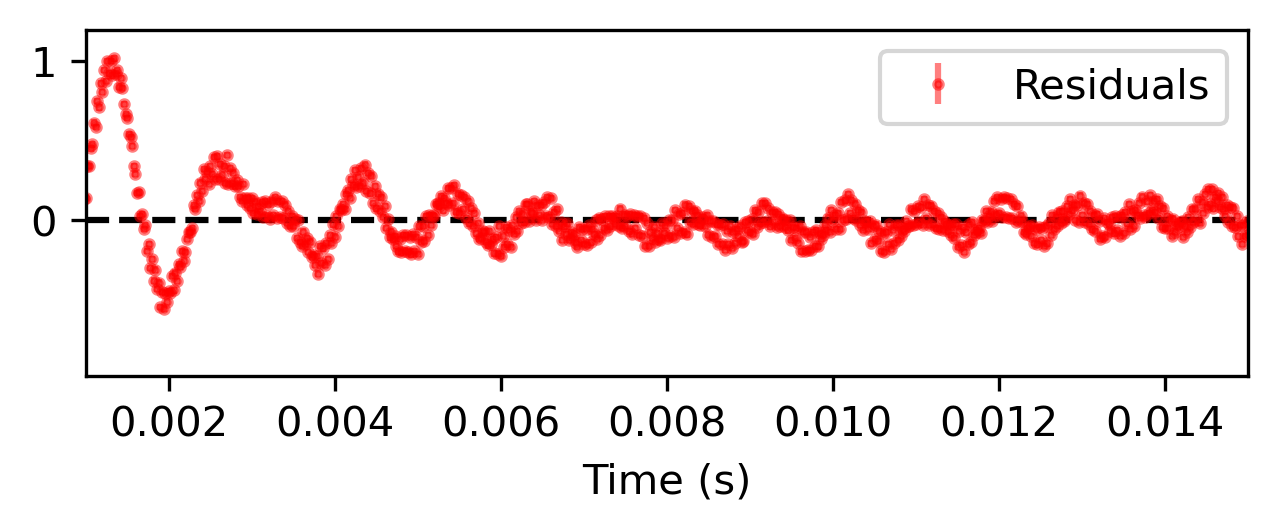

In [547]:
probe_data = raw_probe_pump_data['run1']['y2'] - raw_probe_data['nopump1']['y2']
time = raw_probe_data['nopump1']['x'] / 10

# Plot 1: Raw Data
plt.figure(figsize=(5, 3), dpi=300)
plt.title('a) Raw Data', loc='left')
plt.plot(time, raw_probe_data['nopump1']['y2'], label='No Pump', color='k', linewidth=0.3)
plt.plot(time, raw_probe_pump_data['run1']['y2'], label='Pump', color='r', linewidth=0.3)
plt.legend()
plt.xlim(0.001, 0.015)
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.savefig('figures/raw_data.pdf')
plt.show()

# Plot 2: Subtracted Data
plt.figure(figsize=(5, 3), dpi=300)
plt.title('b) Subtracted Data', loc='left')
plt.plot(time, probe_data, label='Difference', color='b', linewidth=0.3, zorder=0)
plt.scatter(time[hyperfine_peaks['run1']], probe_data[hyperfine_peaks['run1']], color='r', s=5, alpha=0.5)
plt.legend()
plt.xlim(0.001, 0.015)
plt.xlabel('Time (s)')
plt.axvspan(time[118], time[157], color='lightblue', alpha=0.5, zorder=0)
plt.axvspan(time[245], time[265], color='mistyrose', alpha=0.5, zorder=0)
plt.axvspan(time[503], time[512], color='beige', alpha=0.5, zorder=0)
plt.axvspan(time[697], time[708], color='lavender', alpha=0.5, zorder=0)
plt.savefig('figures/subtracted_data.pdf')
plt.show()

# Plot 3: Interferometer
plt.figure(figsize=(5, 3), dpi=300)
plt.title('c) Interferometer', loc='left')
plt.plot(time, raw_probe_pump_data['run1']['y3'], label='Interferometer', color='k', linewidth=0.7, zorder=0)
plt.plot(time, interference_model(time, *parameters), label='Fit', alpha=0.7, color='purple')
plt.legend()
plt.xlim(0.001, 0.015)
plt.xticks([])
plt.savefig('figures/interferometer.pdf')
plt.show()

# Plot 4: Residuals
plt.figure(figsize=(5, 1.5), dpi=300)
plt.errorbar(time, raw_probe_pump_data['run1']['y3'] - interference_model(time, *parameters), yerr=0.02, label='Residuals', color='r', alpha=0.5, fmt='o', markersize=2)
plt.hlines(0, 0.001, 0.015, color='k', linestyle='--')
plt.xlim(0.001, 0.015)
plt.ylim(-0.98, 1.2)
plt.legend()
plt.xlabel('Time (s)')
plt.savefig('figures/residuals.pdf')
plt.show()

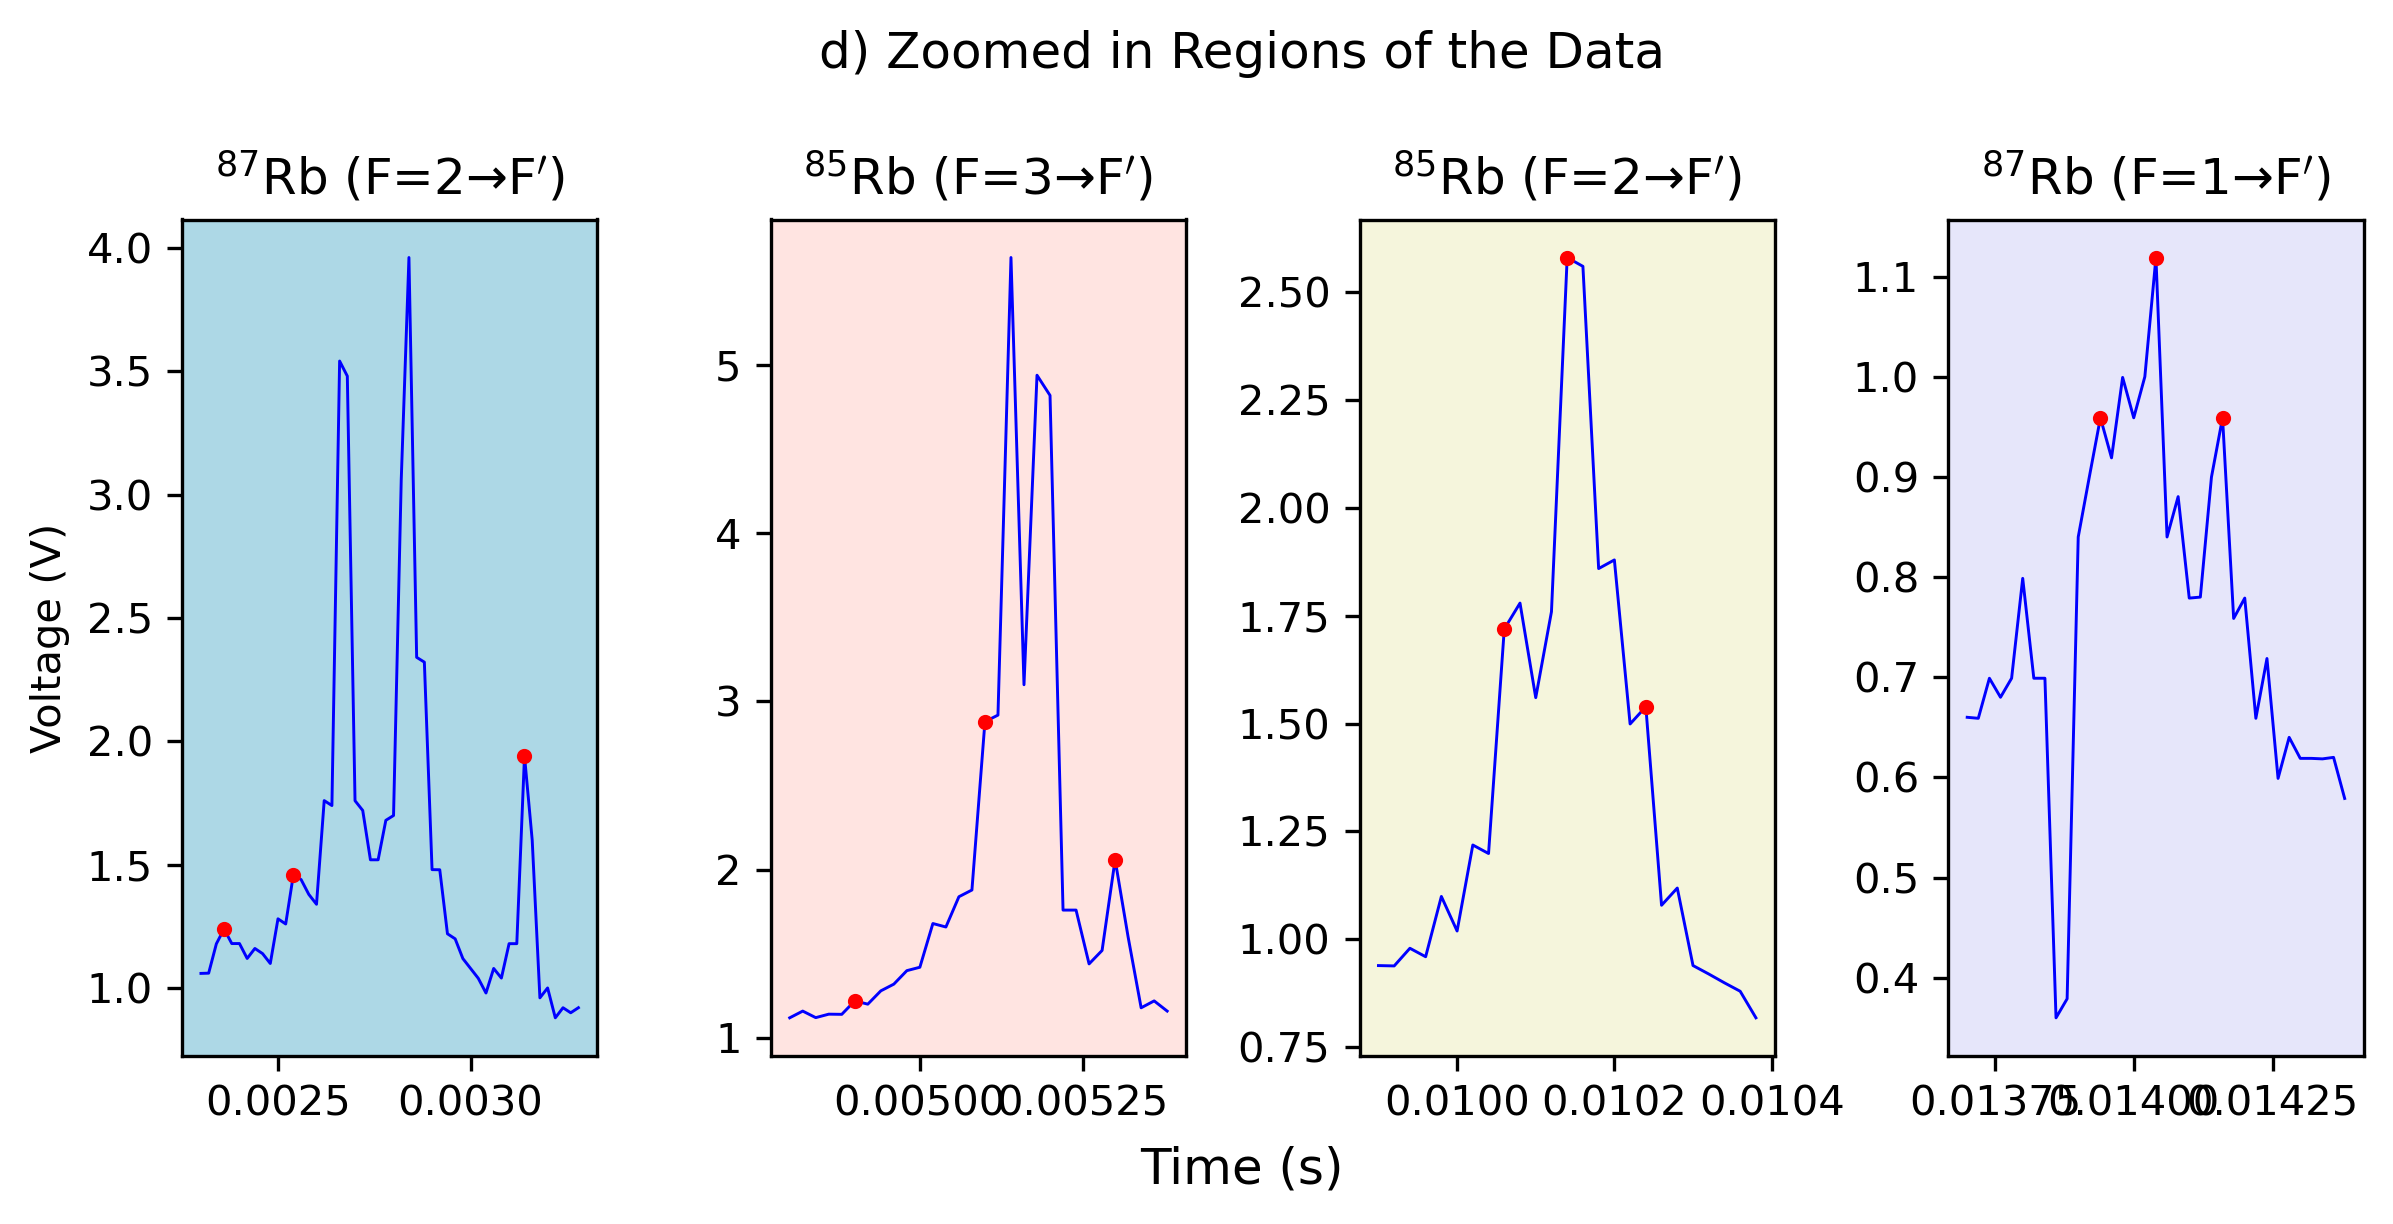

In [561]:
# plt.xlim(115, 165)
# plt.xlim(240, 270)
# plt.xlim(495, 520)
# plt.xlim(685,720)

t1 = time[115:165]
t2 = time[240:270]
t3 = time[495:520]
t4 = time[685:720]

p1 = probe_data[115:165]
p2 = probe_data[240:270]
p3 = probe_data[495:520]
p4 = probe_data[685:720]

# make a subplot for each region
fig, axs = plt.subplots(1, 4, figsize=(8,4), dpi=300)
fig.suptitle('d) Zoomed in Regions of the Data')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.supxlabel('Time (s)')

# plot the data and peaks from that region
axs[0].set_title(r'$^{87}$Rb (F=2$\to$F$^{\prime}$)') 
axs[0].plot(t1, p1, color='b', linewidth=0.7, zorder=0)
axs[0].scatter(t1[[118 - 115, 127- 115, 157- 115]], p1[[118- 115, 127- 115, 157- 115]], color='r', s = 7, label = 'Resonance peaks')
axs[0].set_ylabel('Voltage (V)')
axs[0].set_facecolor('lightblue')

axs[1].set_title(r'$^{85}$Rb (F=3$\to$F$^{\prime}$)')
axs[1].plot(t2, p2, color='b', linewidth=0.7, zorder=0)
axs[1].scatter(t2[[245-240, 255-240, 265-240]], p2[[245-240, 255-240, 265-240]], color='r', s = 7, label = 'Resonance peaks')
axs[1].set_facecolor('mistyrose')

axs[2].set_title(r'$^{85}$Rb (F=2$\to$F$^{\prime}$)')
axs[2].plot(t3, p3, color='b', linewidth=0.7, zorder=0)
axs[2].scatter(t3[[503-495, 507-495, 512-495]], p3[[503-495, 507-495, 512-495]], color='r', s = 7, label = 'Resonance peaks')
axs[2].set_facecolor('beige')

axs[3].set_title(r'$^{87}$Rb (F=1$\to$F$^{\prime}$)')
axs[3].plot(t4, p4, color='b', linewidth=0.7, zorder=0)
axs[3].scatter(t4[[697-685, 702-685, 708-685]], p4[[697-685, 702-685, 708-685]], color='r', s = 7, label = 'Resonance peaks')
axs[3].set_facecolor('lavender')

plt.savefig('figures/zoomins.pdf')
# plt.tight_layout()